<a href="https://colab.research.google.com/github/aragornchunletia/Mixtape/blob/main/ols(clusters).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_cluster
from scipy.stats import t

In [2]:
#create clusters
def create_clusters(param = (0.1,0.5), n = 1000, n_clusters = 50 , rho = 0.5):
  sigma_i = np.array([[1,0],[0,1-rho]])
  values_i = mvn.rvs(mean = np.array([0,0]), cov = sigma_i, size = n)

  sigma_cl = np.array([[1,0],[0,rho]])
  values_cl = mvn.rvs(mean = np.array([0,0]), cov = sigma_cl, size = n_clusters)

  cluster_name = np.repeat(np.arange(1,n_clusters + 1), n // n_clusters)

  x = values_i[:,0] + np.repeat(values_cl[:,0], n // n_clusters)
  error = values_i[:,1] + np.repeat(values_cl[:,1], n // n_clusters)

  y = param[0] + param[1] * x+error

  df = pd.DataFrame({'x':x, 'y':y, 'cluster':cluster_name})
  return df

In [12]:
def cluster_sim(param=(0.1,0.5), n=1000, n_clusters = 50, rho=0.5, cluster_robust = False):

  df = create_clusters(param, n, n_clusters, rho)
  model = smf.ols("y ~ x", data = df).fit()
  b1 = model.params['x']

  if not cluster_robust:
    se = model.bse['x']
    ci_lower , ci_upper = model.conf_int().loc['x']
  else:
    cluster_var = model.cov_params(model , df['cluster'])
    se = np.sqrt(cluster_var[1,1])
    t_critical = t.ppf(0.95, n - 2)
    ci_lower = b1 - t_critical * se
    ci_upper = b1 + t_critical * se
  return(b1,se,ci_lower,ci_upper)



In [13]:
def run_simulation(n_simulations = 1000, params=(1.0,0.5),n=1000,n_clusters=50,rho=0.5 ):

  res = pd.DataFrame(columns = ['b1','se','ci_lower','ci_upper'])

  for _ in range(n_simulations):
    row = cluster_sim(params, n, n_clusters)
    res.loc[len(res)] = row

  res['param_caught'] = (res['ci_lower'] <= params[1]) & (res['ci_upper'] >= params[1])
  return res

In [15]:
#data without clusters rho = 0, beta_0 = 0.4 , beta_1 = 0
sims_without_clusters = run_simulation(params=(0.4,0),rho = 0)

In [16]:
sims_without_clusters['param_caught'].value_counts()

,count
param_caught,
True,606
False,394


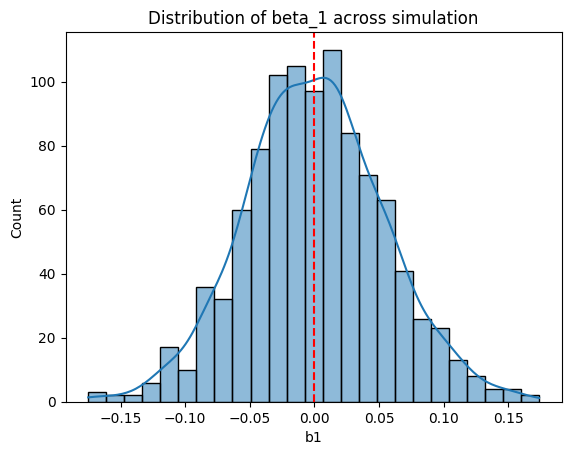

In [17]:
sns.histplot(sims_without_clusters['b1'] , kde=True)
plt.axvline(x=0.0, color='r', linestyle='--')
plt.title("Distribution of beta_1 across simulation")
plt.show()

In [18]:
samples_without_cluster = sims_without_clusters.sample(frac=0.1)
samples_without_cluster = samples_without_cluster.sort_values('b1').reset_index().drop(columns='index')
samples_without_cluster.head()

,b1,se,ci_lower,ci_upper,param_caught
0,-0.115682,0.025163,-0.165061,-0.066304,False
1,-0.111851,0.021923,-0.154871,-0.068830,False
2,-0.105763,0.021936,-0.148809,-0.062717,False
3,-0.097932,0.020329,-0.137824,-0.058039,False
4,-0.081408,0.020988,-0.122594,-0.040222,False


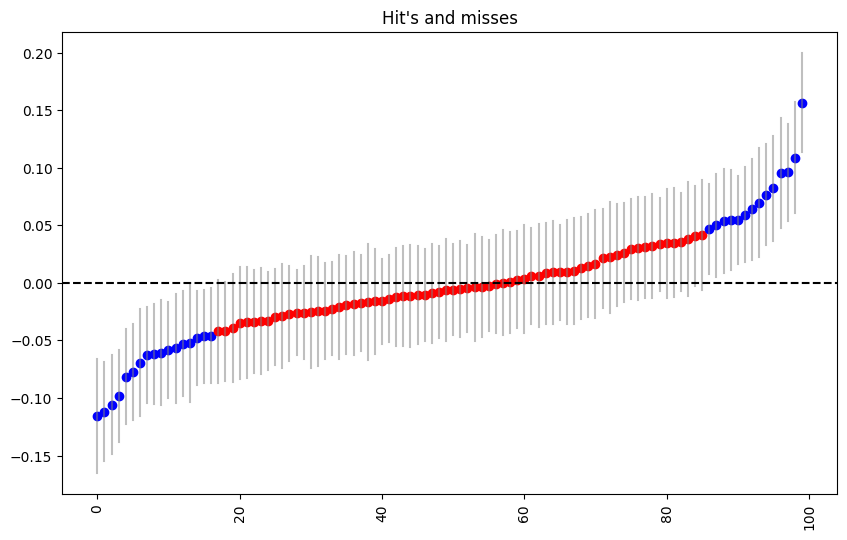

In [19]:
plt.figure(figsize=(10, 6))
for index,row in samples_without_cluster.iterrows():
  plt.plot([index , index] , [row['ci_lower'] , row['ci_upper']], color='gray', alpha=0.5 )
  plt.scatter(index , row['b1'], color='red' if row['param_caught'] else 'blue')
plt.axhline(y=0.0, color = 'black', linestyle = '--')
plt.title("Hit's and misses")
plt.xticks(rotation = 90)
plt.show()


In [20]:
#type 1 errors
type1_error = 1 - samples_without_cluster['param_caught'].mean()
print(f"Type 1 error: {type1_error}")


Type 1 error: 0.31000000000000005


In [21]:
samples_without_cluster['param_caught'].value_counts()

,count
param_caught,
True,69
False,31
